# Training Analysis

In [26]:
from data.loader import define_loaders
from utils.utils import load_config
from utils.torch import count_parameters, seed_everything, load_model_weights
from model_zoo.models import define_model
import os 

In [27]:
from utils.plot import plot_metrics, plot_training_loss
import pandas as pd

exp_dir = "/home/ubuntu/project/sentinel-2-ai-processor/src/results/"
experience ="2025-04-26_08-48-49"
config = load_config(config_path=f"{exp_dir}/{experience}/config.yaml")

In [ ]:
df_loss = pd.read_csv(f"{exp_dir}/{experience}/metrics/losses.csv")
df_ssim = pd.read_csv(f"{exp_dir}/{experience}/metrics/ssim_metrics.csv")
df_sam = pd.read_csv(f"{exp_dir}/{experience}/metrics/sam_metrics.csv")
df_rmse = pd.read_csv(f"{exp_dir}/{experience}/metrics/rmse_metrics.csv")
df_psnr = pd.read_csv(f"{exp_dir}/{experience}/metrics/psnr_metrics.csv")

In [ ]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_psnr, bands=bands, title="Dataset V1 - PSRN",
             log_scale=False,
             y_label="PSNR",
             verbose=True,
             save=False,
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")

plot_metrics(df_ssim, bands=bands, title="Dataset V1 - SSIM",
             log_scale=False,
             y_label="SSIM",
             verbose=True,
             save=False,
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")

plot_metrics(df_sam, bands=bands, title="Dataset V1 - SAM",
             log_scale=False,
             y_label="SAM",
             verbose=True,
             save=False,
             save_path="sam_metrics_plot.svg",
             color_palette="plasma")

plot_metrics(df_rmse, bands=bands, title="Dataset V1 - RMSE",
             log_scale=False,
             y_label="RMSE",
             verbose=True,
             save=False,
             save_path="rmse_metrics_plot.svg",
             color_palette="plasma")

In [ ]:
plot_training_loss(df=df_loss,
                    title="Training and Validation Loss",
                    y_label="Loss",
                    log_scale=False,
                    verbose=True,
                    save=False,
                    save_path="loss_plot.svg",
                    color_palette="plasma")

## Load Config

In [28]:
config = load_config(config_path=f"{exp_dir}/{experience}/config.yaml")
base_dir = config["DATASET"]["base_dir"]
version = config['DATASET']['version']
bands = config['DATASET']['bands']
resize = config['TRAINING']['resize']
num_workers = config['TRAINING']['num_workers']

## Create Dataset

In [80]:
def prepare_paths(path_dir):
    
    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))
    
    return df_input, df_output

In [81]:
test_dir = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_test_input, df_test_output =  prepare_paths(test_dir)

In [82]:
df_test_input.head(2)

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover,path
0,S2A_MSIL1C_20180105T103421_N0500_R108_T32TMT,S2A_MSIL1C_20180105T103421_N0500_R108_T32TMT_2...,/eodata/Sentinel-2/MSI/L1C_N0500/2018/01/05/S2...,geography'SRID=4326;POLYGON ((7.66286529044567...,"{'type': 'Polygon', 'coordinates': [[[7.662865...",60.705665,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...
1,S2B_MSIL1C_20180107T102359_N0500_R065_T32TPS,S2B_MSIL1C_20180107T102359_N0500_R065_T32TPS_2...,/eodata/Sentinel-2/MSI/L1C_N0500/2018/01/07/S2...,geography'SRID=4326;POLYGON ((11.7513728834118...,"{'type': 'Polygon', 'coordinates': [[[11.75137...",98.293253,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...


In [87]:
from data.dataset import Sentinel2Dataset

test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)
test_loader = define_loaders(
    train_dataset=test_dataset,
    val_dataset=None,
    train=False,
    batch_size=1,
    num_workers=config['TRAINING']['num_workers'])

In [ ]:
df_test_output.head(2)

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover,path
0,S2A_MSIL1C_20180105T103421_N0500_R108_T32TMT,S2A_MSIL2A_20180105T103421_N0500_R108_T32TMT_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/05/S2...,geography'SRID=4326;POLYGON ((7.66286529044567...,"{'type': 'Polygon', 'coordinates': [[[7.662865...",76.968253,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...
1,S2B_MSIL1C_20180107T102359_N0500_R065_T32TPS,S2B_MSIL2A_20180107T102359_N0500_R065_T32TPS_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/07/S2...,geography'SRID=4326;POLYGON ((11.7513728834118...,"{'type': 'Polygon', 'coordinates': [[[11.75137...",96.654195,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...


## Load Model 

In [113]:
import torch

weights_path = f"{exp_dir}/{experience}/checkpoints/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                     encoder_name=config["MODEL"]["encoder_name"],
                     in_channel=len(bands),
                     out_channels=len(bands),
                     activation=None)
# Model Test - load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

2025-04-26 20:13:44.060 | INFO     | utils.torch:load_model_weights:103 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/src/results//2025-04-26_08-48-49/checkpoints/best_model.pth



## Test Dataset inference

In [114]:
from tqdm import tqdm

from training.metrics import MultiSpectralMetrics

test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

indiv_metrics = []
def test_model(model, test_loader, device, metrics_tracker):
    model.eval()
    metrics_tracker.reset()
    with torch.no_grad():
        with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:
            t.set_description("Testing")
            for x_data, y_data in test_loader:
                x_data, y_data = x_data.to(device), y_data.to(device)
                outputs = model(x_data)
                metrics_tracker.update(outputs, y_data)
                
                indiv_metrics.append(test_metrics_tracker.compute())
                t.update(x_data.size(0))
                
    return metrics_tracker.compute(), metrics_tracker

test_metrics_avg, test_metrics = test_model(model, test_loader, device, test_metrics_tracker)

Testing: 100%|████████████████████████████████████████████████████| 600/600 [01:02<00:00,  9.59it/s]


In [ ]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

# Prepare the dictionary to store per-band metrics
metrics_dict = {}
for band in test_metrics_tracker.bands:
    for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
        metrics_dict[f"{metric_name}_{band}"] = []

# Reset tracker
test_metrics_tracker.reset()

# Model evaluation
model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:
        
        for x_data, y_data in test_loader:
            x_data, y_data = x_data.to(device), y_data.to(device)
            outputs = model(x_data)
            
            print(outputs[0,0,:,:].min(),outputs[0,0,:,:].max())
            
            # Reset tracker for individual image
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data)
            metrics = test_metrics_tracker.compute()            

            # Store per-band metrics
            for band in test_metrics_tracker.bands:
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    value = metrics[band][metric_name]
                    metrics_dict[f"{metric_name}_{band}"].append(value)

            t.update(x_data.size(0))

# After the loop, merge the metrics into the original dataframe
for column_name, values in metrics_dict.items():
    df_test_output[column_name] = values

# df_test_output.to_csv(f"{exp_dir}/{experience}/test_metrics_output.csv", index=False)


  0%|                                                                       | 0/600 [00:00<?, ?it/s]

  0%|                                                               | 1/600 [00:02<24:53,  2.49s/it]

tensor(-0.0479, device='cuda:0') tensor(1.0431, device='cuda:0')
tensor(-0.0533, device='cuda:0') tensor(1.0301, device='cuda:0')


  0%|▎                                                              | 3/600 [00:02<06:41,  1.49it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0409, device='cuda:0')
tensor(-0.0265, device='cuda:0') tensor(1.0283, device='cuda:0')


  1%|▋                                                              | 6/600 [00:03<02:31,  3.91it/s]

tensor(-0.0345, device='cuda:0') tensor(1.0396, device='cuda:0')
tensor(-0.0575, device='cuda:0') tensor(1.0477, device='cuda:0')
tensor(-0.0401, device='cuda:0') tensor(1.0560, device='cuda:0')
tensor(-0.0657, device='cuda:0') tensor(1.0810, device='cuda:0')


  2%|▉                                                              | 9/600 [00:03<01:27,  6.74it/s]

tensor(-0.0359, device='cuda:0') tensor(1.0445, device='cuda:0')
tensor(-0.0560, device='cuda:0') tensor(1.1149, device='cuda:0')
tensor(-0.0909, device='cuda:0') tensor(1.0677, device='cuda:0')


  2%|█▏                                                            | 11/600 [00:03<01:21,  7.25it/s]

tensor(-0.0500, device='cuda:0') tensor(1.0275, device='cuda:0')
tensor(-0.0636, device='cuda:0') tensor(1.0315, device='cuda:0')


  2%|█▍                                                            | 14/600 [00:03<01:25,  6.88it/s]

tensor(-0.0389, device='cuda:0') tensor(1.0418, device='cuda:0')
tensor(-0.0365, device='cuda:0') tensor(1.0598, device='cuda:0')


  3%|█▊                                                            | 17/600 [00:04<01:08,  8.47it/s]

tensor(-0.0686, device='cuda:0') tensor(1.1174, device='cuda:0')
tensor(-0.1003, device='cuda:0') tensor(1.0608, device='cuda:0')
tensor(-0.0363, device='cuda:0') tensor(1.0458, device='cuda:0')
tensor(-0.0394, device='cuda:0') tensor(1.0187, device='cuda:0')
tensor(-0.0313, device='cuda:0') tensor(1.0226, device='cuda:0')


  4%|██▏                                                           | 21/600 [00:04<00:42, 13.48it/s]

tensor(-0.0539, device='cuda:0') tensor(1.0637, device='cuda:0')
tensor(-0.0409, device='cuda:0') tensor(1.0658, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0622, device='cuda:0')


  4%|██▍                                                           | 23/600 [00:04<00:48, 11.89it/s]

tensor(-0.0554, device='cuda:0') tensor(1.0341, device='cuda:0')
tensor(-0.0398, device='cuda:0') tensor(1.0773, device='cuda:0')


  4%|██▌                                                           | 25/600 [00:04<00:58,  9.89it/s]

tensor(-0.0635, device='cuda:0') tensor(1.0116, device='cuda:0')
tensor(-0.0557, device='cuda:0') tensor(1.0277, device='cuda:0')


  5%|██▉                                                           | 29/600 [00:05<01:00,  9.48it/s]

tensor(-0.0389, device='cuda:0') tensor(1.0562, device='cuda:0')
tensor(-0.0342, device='cuda:0') tensor(1.0255, device='cuda:0')
tensor(-0.0337, device='cuda:0') tensor(1.0318, device='cuda:0')


  5%|███▏                                                          | 31/600 [00:05<00:54, 10.47it/s]

tensor(-0.0601, device='cuda:0') tensor(1.0643, device='cuda:0')
tensor(-0.0451, device='cuda:0') tensor(1.0667, device='cuda:0')
tensor(-0.0539, device='cuda:0') tensor(1.0303, device='cuda:0')


  6%|███▌                                                          | 34/600 [00:06<01:20,  7.00it/s]

tensor(-0.0408, device='cuda:0') tensor(1.0716, device='cuda:0')
tensor(-0.0396, device='cuda:0') tensor(1.0348, device='cuda:0')


  6%|███▊                                                          | 37/600 [00:06<01:07,  8.38it/s]

tensor(-0.0383, device='cuda:0') tensor(1.0558, device='cuda:0')
tensor(-0.0264, device='cuda:0') tensor(1.0631, device='cuda:0')
tensor(-0.0682, device='cuda:0') tensor(1.1205, device='cuda:0')
tensor(-0.0675, device='cuda:0') tensor(1.0318, device='cuda:0')


  7%|████▏                                                         | 40/600 [00:06<00:48, 11.53it/s]

tensor(-0.0415, device='cuda:0') tensor(1.0547, device='cuda:0')
tensor(-0.0509, device='cuda:0') tensor(1.0276, device='cuda:0')
tensor(-0.0565, device='cuda:0') tensor(1.0797, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0769, device='cuda:0')


  7%|████▍                                                         | 43/600 [00:06<00:46, 12.09it/s]

tensor(-0.0407, device='cuda:0') tensor(1.0537, device='cuda:0')
tensor(-0.0624, device='cuda:0') tensor(1.0751, device='cuda:0')


  8%|████▋                                                         | 45/600 [00:07<00:54, 10.24it/s]

tensor(-0.0628, device='cuda:0') tensor(1.0650, device='cuda:0')
tensor(-0.0521, device='cuda:0') tensor(1.0512, device='cuda:0')


  8%|█████                                                         | 49/600 [00:07<00:57,  9.66it/s]

tensor(-0.0462, device='cuda:0') tensor(1.0685, device='cuda:0')
tensor(-0.0513, device='cuda:0') tensor(1.0449, device='cuda:0')
tensor(-0.0365, device='cuda:0') tensor(1.0431, device='cuda:0')
tensor(-0.0556, device='cuda:0') tensor(1.0497, device='cuda:0')


  8%|█████▎                                                        | 51/600 [00:07<00:50, 10.82it/s]

tensor(-0.0350, device='cuda:0') tensor(1.0691, device='cuda:0')
tensor(-0.0488, device='cuda:0') tensor(1.0780, device='cuda:0')


  9%|█████▍                                                        | 53/600 [00:08<01:04,  8.51it/s]

tensor(-0.0332, device='cuda:0') tensor(1.0277, device='cuda:0')


  9%|█████▋                                                        | 55/600 [00:08<01:21,  6.67it/s]

tensor(-0.0516, device='cuda:0') tensor(1.0478, device='cuda:0')
tensor(-0.0470, device='cuda:0') tensor(1.1053, device='cuda:0')
tensor(-0.0315, device='cuda:0') tensor(1.0362, device='cuda:0')


 10%|██████▏                                                       | 60/600 [00:08<00:53, 10.01it/s]

tensor(-0.0259, device='cuda:0') tensor(1.0407, device='cuda:0')
tensor(-0.0500, device='cuda:0') tensor(1.0351, device='cuda:0')
tensor(-0.0531, device='cuda:0') tensor(1.0354, device='cuda:0')
tensor(-0.0278, device='cuda:0') tensor(1.0424, device='cuda:0')
tensor(-0.0534, device='cuda:0') tensor(1.0383, device='cuda:0')


 10%|██████▍                                                       | 62/600 [00:09<01:01,  8.81it/s]

tensor(-0.0667, device='cuda:0') tensor(1.0816, device='cuda:0')
tensor(-0.0357, device='cuda:0') tensor(1.0445, device='cuda:0')


 11%|██████▉                                                       | 67/600 [00:09<00:55,  9.64it/s]

tensor(-0.0314, device='cuda:0') tensor(1.0525, device='cuda:0')
tensor(-0.0515, device='cuda:0') tensor(1.0495, device='cuda:0')
tensor(-0.0526, device='cuda:0') tensor(1.0497, device='cuda:0')


 12%|███████▏                                                      | 70/600 [00:09<00:39, 13.28it/s]

tensor(-0.0385, device='cuda:0') tensor(1.0606, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0624, device='cuda:0')
tensor(-0.0460, device='cuda:0') tensor(1.0516, device='cuda:0')
tensor(-0.0613, device='cuda:0') tensor(1.0774, device='cuda:0')


 12%|███████▍                                                      | 72/600 [00:10<00:48, 10.79it/s]

tensor(-0.0507, device='cuda:0') tensor(1.0195, device='cuda:0')
tensor(-0.0527, device='cuda:0') tensor(1.0664, device='cuda:0')


 12%|███████▋                                                      | 74/600 [00:10<00:57,  9.17it/s]

tensor(-0.0647, device='cuda:0') tensor(1.0246, device='cuda:0')
tensor(-0.0504, device='cuda:0') tensor(1.0974, device='cuda:0')


 13%|███████▊                                                      | 76/600 [00:10<01:02,  8.44it/s]

tensor(-0.0496, device='cuda:0') tensor(1.0539, device='cuda:0')
tensor(-0.0258, device='cuda:0') tensor(1.0239, device='cuda:0')
tensor(-0.0679, device='cuda:0') tensor(1.0578, device='cuda:0')


 14%|████████▎                                                     | 81/600 [00:10<00:46, 11.21it/s]

tensor(-0.0620, device='cuda:0') tensor(1.0562, device='cuda:0')
tensor(-0.0309, device='cuda:0') tensor(1.0967, device='cuda:0')
tensor(-0.0361, device='cuda:0') tensor(1.0316, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0204, device='cuda:0')


 14%|████████▉                                                     | 86/600 [00:11<00:34, 14.87it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0457, device='cuda:0')
tensor(-0.0339, device='cuda:0') tensor(1.0865, device='cuda:0')
tensor(-0.0455, device='cuda:0') tensor(1.0490, device='cuda:0')
tensor(-0.0472, device='cuda:0') tensor(1.0319, device='cuda:0')
tensor(-0.0586, device='cuda:0') tensor(1.0583, device='cuda:0')


 15%|█████████▎                                                    | 90/600 [00:11<00:41, 12.35it/s]

tensor(-0.0304, device='cuda:0') tensor(1.0738, device='cuda:0')
tensor(-0.0345, device='cuda:0') tensor(1.0166, device='cuda:0')
tensor(-0.0664, device='cuda:0') tensor(1.0547, device='cuda:0')
tensor(-0.0621, device='cuda:0') tensor(1.0356, device='cuda:0')


 16%|█████████▌                                                    | 93/600 [00:11<00:32, 15.52it/s]

tensor(-0.0317, device='cuda:0') tensor(1.0224, device='cuda:0')
tensor(-0.0631, device='cuda:0') tensor(1.0230, device='cuda:0')
tensor(-0.0471, device='cuda:0') tensor(1.0359, device='cuda:0')
tensor(-0.0261, device='cuda:0') tensor(1.0367, device='cuda:0')


 16%|██████████▏                                                   | 98/600 [00:12<00:35, 14.19it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0349, device='cuda:0')
tensor(-0.0647, device='cuda:0') tensor(1.0854, device='cuda:0')
tensor(-0.0467, device='cuda:0') tensor(1.0664, device='cuda:0')


 17%|██████████▎                                                  | 102/600 [00:12<00:48, 10.23it/s]

tensor(-0.0416, device='cuda:0') tensor(1.0349, device='cuda:0')
tensor(-0.0624, device='cuda:0') tensor(1.0303, device='cuda:0')
tensor(-0.0424, device='cuda:0') tensor(1.0605, device='cuda:0')
tensor(-0.0509, device='cuda:0') tensor(1.0879, device='cuda:0')


 18%|██████████▋                                                  | 105/600 [00:12<00:38, 12.83it/s]

tensor(-0.0537, device='cuda:0') tensor(1.0540, device='cuda:0')
tensor(-0.0468, device='cuda:0') tensor(1.0951, device='cuda:0')
tensor(-0.0509, device='cuda:0') tensor(1.0653, device='cuda:0')
tensor(-0.0345, device='cuda:0') tensor(1.0334, device='cuda:0')


 18%|███████████▎                                                 | 111/600 [00:13<00:46, 10.58it/s]

tensor(-0.0370, device='cuda:0') tensor(1.0304, device='cuda:0')
tensor(-0.0484, device='cuda:0') tensor(1.0437, device='cuda:0')
tensor(-0.0513, device='cuda:0') tensor(1.0286, device='cuda:0')
tensor(-0.0535, device='cuda:0') tensor(1.0511, device='cuda:0')
tensor(-0.0367, device='cuda:0') tensor(1.0365, device='cuda:0')


 19%|███████████▌                                                 | 114/600 [00:13<00:36, 13.35it/s]

tensor(-0.0311, device='cuda:0') tensor(1.0793, device='cuda:0')
tensor(-0.0230, device='cuda:0') tensor(1.0203, device='cuda:0')
tensor(-0.0556, device='cuda:0') tensor(1.0308, device='cuda:0')
tensor(-0.0402, device='cuda:0') tensor(1.0413, device='cuda:0')
tensor(-0.0337, device='cuda:0') tensor(1.0293, device='cuda:0')


 20%|███████████▉                                                 | 118/600 [00:14<01:04,  7.45it/s]

tensor(-0.0356, device='cuda:0') tensor(1.0264, device='cuda:0')
tensor(-0.0660, device='cuda:0') tensor(1.0551, device='cuda:0')
tensor(-0.0569, device='cuda:0') tensor(1.0348, device='cuda:0')


 20%|████████████▎                                                | 121/600 [00:14<00:48,  9.95it/s]

tensor(-0.0356, device='cuda:0') tensor(1.1052, device='cuda:0')
tensor(-0.0637, device='cuda:0') tensor(0.9964, device='cuda:0')
tensor(-0.0552, device='cuda:0') tensor(1.0103, device='cuda:0')
tensor(-0.0311, device='cuda:0') tensor(1.0301, device='cuda:0')


 20%|████████████▌                                                | 123/600 [00:14<00:51,  9.29it/s]

tensor(-0.0644, device='cuda:0') tensor(1.0361, device='cuda:0')
tensor(-0.0294, device='cuda:0') 

 21%|████████████▋                                                | 125/600 [00:15<01:02,  7.64it/s]

tensor(1.0535, device='cuda:0')
tensor(-0.0355, device='cuda:0') tensor(1.0686, device='cuda:0')
tensor(-0.0439, device='cuda:0') tensor(1.0657, device='cuda:0')


 22%|█████████████▎                                               | 131/600 [00:15<00:43, 10.71it/s]

tensor(-0.0401, device='cuda:0') tensor(1.0439, device='cuda:0')
tensor(-0.0414, device='cuda:0') tensor(1.0443, device='cuda:0')
tensor(-0.0207, device='cuda:0') tensor(1.0186, device='cuda:0')
tensor(-0.0371, device='cuda:0') tensor(1.0350, device='cuda:0')
tensor(-0.0438, device='cuda:0') tensor(1.0829, device='cuda:0')
tensor(-0.0526, device='cuda:0') tensor(1.0566, device='cuda:0')


 23%|██████████████                                               | 138/600 [00:16<00:26, 17.75it/s]

tensor(-0.0701, device='cuda:0') tensor(1.0549, device='cuda:0')
tensor(-0.0348, device='cuda:0') tensor(1.0882, device='cuda:0')
tensor(-0.0448, device='cuda:0') tensor(1.0427, device='cuda:0')
tensor(-0.0495, device='cuda:0') tensor(1.0551, device='cuda:0')
tensor(-0.0584, device='cuda:0') tensor(1.0605, device='cuda:0')


 24%|██████████████▎                                              | 141/600 [00:16<00:37, 12.21it/s]

tensor(-0.0533, device='cuda:0') tensor(1.0311, device='cuda:0')
tensor(-0.0317, device='cuda:0') tensor(1.0280, device='cuda:0')
tensor(-0.0343, device='cuda:0') tensor(1.0975, device='cuda:0')
tensor(-0.0503, device='cuda:0') tensor(1.0604, device='cuda:0')
tensor(-0.0535, device='cuda:0') tensor(1.0499, device='cuda:0')


 24%|██████████████▊                                              | 146/600 [00:16<00:36, 12.60it/s]

tensor(-0.0378, device='cuda:0') tensor(1.0158, device='cuda:0')
tensor(-0.0465, device='cuda:0') tensor(1.0235, device='cuda:0')
tensor(-0.0346, device='cuda:0') tensor(1.0349, device='cuda:0')


 25%|███████████████▎                                             | 151/600 [00:17<00:44, 10.14it/s]

tensor(-0.0470, device='cuda:0') tensor(1.0762, device='cuda:0')
tensor(-0.0544, device='cuda:0') tensor(1.0792, device='cuda:0')
tensor(-0.0686, device='cuda:0') tensor(1.0286, device='cuda:0')
tensor(-0.0334, device='cuda:0') tensor(1.0610, device='cuda:0')
tensor(-0.0506, device='cuda:0') tensor(1.0551, device='cuda:0')
tensor(-0.0462, device='cuda:0') tensor(1.0339, device='cuda:0')


 26%|███████████████▋                                             | 154/600 [00:17<00:34, 12.79it/s]

tensor(-0.0533, device='cuda:0') tensor(1.0194, device='cuda:0')
tensor(-0.0610, device='cuda:0') tensor(1.0613, device='cuda:0')
tensor(-0.0465, device='cuda:0') tensor(1.0658, device='cuda:0')
tensor(-0.0390, device='cuda:0') tensor(1.0363, device='cuda:0')


 26%|███████████████▊                                             | 156/600 [00:18<01:07,  6.55it/s]

tensor(-0.0447, device='cuda:0') tensor(1.0881, device='cuda:0')
tensor(-0.0286, device='cuda:0') tensor(1.0238, device='cuda:0')


 27%|████████████████▎                                            | 160/600 [00:18<00:58,  7.48it/s]

tensor(-0.0541, device='cuda:0') tensor(1.0435, device='cuda:0')
tensor(-0.0434, device='cuda:0') tensor(1.0503, device='cuda:0')
tensor(-0.0322, device='cuda:0') tensor(1.0685, device='cuda:0')
tensor(-0.0426, device='cuda:0') tensor(1.0315, device='cuda:0')


 27%|████████████████▌                                            | 163/600 [00:19<00:52,  8.30it/s]

tensor(-0.0381, device='cuda:0') tensor(1.0323, device='cuda:0')
tensor(-0.0325, device='cuda:0') tensor(1.0261, device='cuda:0')


 28%|████████████████▊                                            | 165/600 [00:19<00:55,  7.89it/s]

tensor(-0.0354, device='cuda:0') tensor(1.0263, device='cuda:0')
tensor(-0.0308, device='cuda:0') tensor(1.0529, device='cuda:0')


 28%|████████████████▉                                            | 167/600 [00:19<00:58,  7.43it/s]

tensor(-0.0345, device='cuda:0') tensor(1.0473, device='cuda:0')
tensor(-0.0649, device='cuda:0') tensor(1.0384, device='cuda:0')


 28%|█████████████████▍                                           | 171/600 [00:20<00:40, 10.56it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0343, device='cuda:0')
tensor(-0.0484, device='cuda:0') tensor(1.0410, device='cuda:0')
tensor(-0.0264, device='cuda:0') tensor(1.0260, device='cuda:0')
tensor(-0.0666, device='cuda:0') tensor(1.0522, device='cuda:0')
tensor(-0.0658, device='cuda:0') tensor(1.0825, device='cuda:0')


 29%|█████████████████▉                                           | 176/600 [00:20<00:29, 14.17it/s]

tensor(-0.0535, device='cuda:0') tensor(1.0607, device='cuda:0')
tensor(-0.0579, device='cuda:0') tensor(1.0426, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0447, device='cuda:0')
tensor(-0.0515, device='cuda:0') tensor(1.0575, device='cuda:0')


 30%|██████████████████                                           | 178/600 [00:20<00:38, 10.85it/s]

tensor(-0.0505, device='cuda:0') tensor(1.0288, device='cuda:0')
tensor(-0.0607, device='cuda:0') tensor(1.0479, device='cuda:0')


 30%|██████████████████▎                                          | 180/600 [00:21<00:51,  8.11it/s]

tensor(-0.0518, device='cuda:0') tensor(1.0656, device='cuda:0')
tensor(-0.0462, device='cuda:0') 

 30%|██████████████████▌                                          | 182/600 [00:21<00:44,  9.38it/s]

tensor(1.0425, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0645, device='cuda:0')
tensor(-0.0537, device='cuda:0') tensor(1.0492, device='cuda:0')
tensor(-0.0506, device='cuda:0') tensor(1.0503, device='cuda:0')
tensor(-0.0530, device='cuda:0') tensor(1.0328, device='cuda:0')


 32%|███████████████████▍                                         | 191/600 [00:21<00:23, 17.29it/s]

tensor(-0.0249, device='cuda:0') tensor(1.0651, device='cuda:0')
tensor(-0.0247, device='cuda:0') tensor(1.0516, device='cuda:0')
tensor(-0.0926, device='cuda:0') tensor(1.1319, device='cuda:0')
tensor(-0.0375, device='cuda:0') tensor(1.0211, device='cuda:0')
tensor(-0.0565, device='cuda:0') tensor(1.0446, device='cuda:0')
tensor(-0.0294, device='cuda:0') tensor(1.0773, device='cuda:0')
tensor(-0.0508, device='cuda:0') tensor(1.0538, device='cuda:0')
tensor(-0.0453, device='cuda:0') tensor(1.0453, device='cuda:0')
tensor(-0.0660, device='cuda:0') tensor(1.0559, device='cuda:0')


 32%|███████████████████▋                                         | 194/600 [00:22<00:41,  9.68it/s]

tensor(-0.0250, device='cuda:0') tensor(1.0480, device='cuda:0')
tensor(-0.0502, device='cuda:0') tensor(1.0623, device='cuda:0')


 33%|████████████████████▏                                        | 198/600 [00:22<00:38, 10.53it/s]

tensor(-0.0600, device='cuda:0') tensor(1.0263, device='cuda:0')
tensor(-0.0455, device='cuda:0') tensor(1.0548, device='cuda:0')
tensor(-0.0553, device='cuda:0') tensor(1.0396, device='cuda:0')
tensor(-0.0319, device='cuda:0') tensor(1.0585, device='cuda:0')


 34%|████████████████████▋                                        | 204/600 [00:22<00:28, 13.84it/s]

tensor(-0.0634, device='cuda:0') tensor(1.0841, device='cuda:0')
tensor(-0.0580, device='cuda:0') tensor(1.0230, device='cuda:0')
tensor(-0.0295, device='cuda:0') tensor(1.0269, device='cuda:0')
tensor(-0.0185, device='cuda:0') tensor(1.0272, device='cuda:0')
tensor(-0.0506, device='cuda:0') tensor(1.0886, device='cuda:0')


 34%|████████████████████▉                                        | 206/600 [00:23<00:46,  8.54it/s]

tensor(-0.0657, device='cuda:0') tensor(1.0662, device='cuda:0')
tensor(-0.0590, device='cuda:0') tensor(1.0445, device='cuda:0')
tensor(-0.0291, device='cuda:0') tensor(1.0554, device='cuda:0')


 35%|█████████████████████▎                                       | 210/600 [00:23<00:44,  8.73it/s]

tensor(-0.0500, device='cuda:0') tensor(1.0515, device='cuda:0')
tensor(-0.0283, device='cuda:0') tensor(1.0273, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0502, device='cuda:0')
tensor(-0.0622, device='cuda:0') tensor(1.0550, device='cuda:0')


 36%|█████████████████████▋                                       | 213/600 [00:23<00:33, 11.57it/s]

tensor(-0.0475, device='cuda:0') tensor(1.0538, device='cuda:0')
tensor(-0.0463, device='cuda:0') tensor(1.0535, device='cuda:0')
tensor(-0.0427, device='cuda:0') tensor(1.0231, device='cuda:0')
tensor(-0.0506, device='cuda:0') tensor(1.0587, device='cuda:0')


 36%|█████████████████████▉                                       | 216/600 [00:24<00:32, 11.79it/s]

tensor(-0.1023, device='cuda:0') tensor(1.0508, device='cuda:0')


 37%|██████████████████████▍                                      | 221/600 [00:24<00:40,  9.46it/s]

tensor(-0.0351, device='cuda:0') tensor(1.0375, device='cuda:0')
tensor(-0.0320, device='cuda:0') tensor(1.0357, device='cuda:0')
tensor(-0.0603, device='cuda:0') tensor(1.0198, device='cuda:0')
tensor(-0.0336, device='cuda:0') tensor(1.0252, device='cuda:0')
tensor(-0.0532, device='cuda:0') tensor(1.0423, device='cuda:0')


 37%|██████████████████████▋                                      | 223/600 [00:25<00:36, 10.32it/s]

tensor(-0.0335, device='cuda:0') tensor(1.0623, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0521, device='cuda:0')
tensor(-0.0425, device='cuda:0') tensor(1.0373, device='cuda:0')


 38%|███████████████████████▍                                     | 230/600 [00:25<00:25, 14.58it/s]

tensor(-0.0909, device='cuda:0') tensor(1.0981, device='cuda:0')
tensor(-0.0621, device='cuda:0') tensor(1.0483, device='cuda:0')
tensor(-0.0559, device='cuda:0') tensor(1.1017, device='cuda:0')
tensor(-0.0513, device='cuda:0') tensor(1.0622, device='cuda:0')
tensor(-0.0530, device='cuda:0') tensor(1.0643, device='cuda:0')
tensor(-0.0381, device='cuda:0') tensor(1.0500, device='cuda:0')


 39%|███████████████████████▌                                     | 232/600 [00:25<00:26, 14.14it/s]

tensor(-0.0340, device='cuda:0') tensor(1.0293, device='cuda:0')
tensor(-0.0501, device='cuda:0') tensor(1.0927, device='cuda:0')


 39%|███████████████████████▉                                     | 236/600 [00:26<00:34, 10.64it/s]

tensor(-0.0560, device='cuda:0') tensor(1.0362, device='cuda:0')
tensor(-0.0595, device='cuda:0') tensor(1.0289, device='cuda:0')
tensor(-0.0333, device='cuda:0') tensor(1.0308, device='cuda:0')


 40%|████████████████████████▎                                    | 239/600 [00:26<00:27, 13.32it/s]

tensor(-0.0404, device='cuda:0') tensor(1.0283, device='cuda:0')
tensor(-0.0664, device='cuda:0') tensor(1.0326, device='cuda:0')
tensor(-0.0596, device='cuda:0') tensor(1.0266, device='cuda:0')
tensor(-0.0550, device='cuda:0') tensor(1.0424, device='cuda:0')
tensor(-0.0568, device='cuda:0') tensor(1.0417, device='cuda:0')


 40%|████████████████████████▌                                    | 242/600 [00:26<00:39,  9.00it/s]

tensor(-0.0299, device='cuda:0') tensor(1.0409, device='cuda:0')


 41%|█████████████████████████                                    | 247/600 [00:27<00:34, 10.24it/s]

tensor(-0.0397, device='cuda:0') tensor(1.0481, device='cuda:0')
tensor(-0.0513, device='cuda:0') tensor(1.0440, device='cuda:0')
tensor(-0.0521, device='cuda:0') tensor(1.0305, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0477, device='cuda:0')
tensor(-0.0501, device='cuda:0') tensor(1.0311, device='cuda:0')
tensor(-0.0584, device='cuda:0') tensor(1.0315, device='cuda:0')
tensor(-0.0370, device='cuda:0') tensor(1.0696, device='cuda:0')


 42%|█████████████████████████▍                                   | 250/600 [00:27<00:38,  9.01it/s]

tensor(-0.0374, device='cuda:0') tensor(1.0379, device='cuda:0')
tensor(-0.0627, device='cuda:0') tensor(1.0958, device='cuda:0')
tensor(-0.0453, device='cuda:0') tensor(1.0718, device='cuda:0')


 42%|█████████████████████████▊                                   | 254/600 [00:28<00:42,  8.18it/s]

tensor(-0.0388, device='cuda:0') tensor(1.0815, device='cuda:0')
tensor(-0.0613, device='cuda:0') tensor(1.0696, device='cuda:0')
tensor(-0.0579, device='cuda:0') tensor(1.0602, device='cuda:0')
tensor(-0.0663, device='cuda:0') tensor(1.0362, device='cuda:0')
tensor(-0.0462, device='cuda:0') tensor(1.0444, device='cuda:0')


 43%|██████████████████████████▏                                  | 258/600 [00:28<00:29, 11.73it/s]

tensor(-0.0363, device='cuda:0') tensor(1.0403, device='cuda:0')
tensor(-0.0308, device='cuda:0') tensor(1.0568, device='cuda:0')


 43%|██████████████████████████▍                                  | 260/600 [00:29<00:46,  7.35it/s]

tensor(-0.0530, device='cuda:0') tensor(1.0760, device='cuda:0')
tensor(-0.0338, device='cuda:0') tensor(1.0813, device='cuda:0')


 44%|██████████████████████████▉                                  | 265/600 [00:29<00:32, 10.34it/s]

tensor(-0.0474, device='cuda:0') tensor(1.0409, device='cuda:0')
tensor(-0.0450, device='cuda:0') tensor(1.0284, device='cuda:0')
tensor(-0.0533, device='cuda:0') tensor(1.0245, device='cuda:0')
tensor(-0.0464, device='cuda:0') tensor(1.0386, device='cuda:0')
tensor(-0.0468, device='cuda:0') tensor(1.0532, device='cuda:0')


 45%|███████████████████████████▌                                 | 271/600 [00:29<00:21, 15.13it/s]

tensor(-0.0354, device='cuda:0') tensor(1.0547, device='cuda:0')
tensor(-0.0604, device='cuda:0') tensor(1.1118, device='cuda:0')
tensor(-0.0630, device='cuda:0') tensor(1.0308, device='cuda:0')
tensor(-0.0380, device='cuda:0') tensor(1.0406, device='cuda:0')
tensor(-0.0543, device='cuda:0') tensor(1.0682, device='cuda:0')
tensor(-0.0583, device='cuda:0') tensor(1.0271, device='cuda:0')
tensor(-0.0671, device='cuda:0') tensor(1.0633, device='cuda:0')


 46%|███████████████████████████▊                                 | 274/600 [00:29<00:28, 11.56it/s]

tensor(-0.0669, device='cuda:0') tensor(1.0257, device='cuda:0')


 46%|████████████████████████████                                 | 276/600 [00:30<00:33,  9.61it/s]

tensor(-0.0424, device='cuda:0') tensor(1.0354, device='cuda:0')
tensor(-0.0568, device='cuda:0') tensor(1.0324, device='cuda:0')
tensor(-0.0627, device='cuda:0') tensor(1.0502, device='cuda:0')


 46%|████████████████████████████▎                                | 278/600 [00:30<00:31, 10.24it/s]

tensor(-0.0226, device='cuda:0') tensor(1.0147, device='cuda:0')
tensor(-0.0365, device='cuda:0') tensor(1.0556, device='cuda:0')
tensor(-0.0637, device='cuda:0') 

 47%|████████████████████████████▍                                | 280/600 [00:30<00:34,  9.16it/s]

tensor(1.0420, device='cuda:0')
tensor(-0.0606, device='cuda:0') tensor(1.0492, device='cuda:0')


 47%|████████████████████████████▋                                | 282/600 [00:31<00:42,  7.49it/s]

tensor(-0.0395, device='cuda:0') tensor(1.0668, device='cuda:0')


 48%|████████████████████████████▉                                | 285/600 [00:31<00:34,  9.21it/s]

tensor(-0.0361, device='cuda:0') tensor(1.0507, device='cuda:0')
tensor(-0.0602, device='cuda:0') tensor(1.0906, device='cuda:0')
tensor(-0.0600, device='cuda:0') tensor(1.0799, device='cuda:0')
tensor(-0.0261, device='cuda:0') tensor(1.0264, device='cuda:0')
tensor(-0.0264, device='cuda:0') tensor(1.0856, device='cuda:0')
tensor(-0.0649, device='cuda:0') tensor(1.0562, device='cuda:0')


 48%|█████████████████████████████▎                               | 288/600 [00:31<00:33,  9.41it/s]

tensor(-0.0517, device='cuda:0') tensor(1.0226, device='cuda:0')
tensor(-0.0538, device='cuda:0') tensor(1.0274, device='cuda:0')


 49%|█████████████████████████████▊                               | 293/600 [00:32<00:34,  8.90it/s]

tensor(-0.0615, device='cuda:0') tensor(1.0253, device='cuda:0')
tensor(-0.0227, device='cuda:0') tensor(1.0214, device='cuda:0')
tensor(-0.0678, device='cuda:0') tensor(1.0845, device='cuda:0')


 49%|██████████████████████████████                               | 296/600 [00:32<00:25, 11.93it/s]

tensor(-0.0476, device='cuda:0') tensor(1.0701, device='cuda:0')
tensor(-0.0520, device='cuda:0') tensor(1.1365, device='cuda:0')
tensor(-0.0653, device='cuda:0') tensor(1.0589, device='cuda:0')
tensor(-0.0329, device='cuda:0') tensor(1.0650, device='cuda:0')


 50%|██████████████████████████████▎                              | 298/600 [00:32<00:28, 10.47it/s]

tensor(-0.0442, device='cuda:0') tensor(1.0639, device='cuda:0')
tensor(-0.0653, device='cuda:0') tensor(1.0228, device='cuda:0')


 50%|██████████████████████████████▌                              | 300/600 [00:33<00:32,  9.17it/s]

tensor(-0.0474, device='cuda:0') tensor(1.0540, device='cuda:0')
tensor(-0.0306, device='cuda:0') tensor(1.0610, device='cuda:0')


 50%|██████████████████████████████▋                              | 302/600 [00:33<00:36,  8.13it/s]

tensor(-0.0683, device='cuda:0') tensor(1.0911, device='cuda:0')
tensor(-0.0536, device='cuda:0') tensor(1.0854, device='cuda:0')
tensor(-0.0318, device='cuda:0') tensor(1.1135, device='cuda:0')
tensor(-0.0304, device='cuda:0') tensor(1.0408, device='cuda:0')


 51%|███████████████████████████████▎                             | 308/600 [00:33<00:21, 13.62it/s]

tensor(-0.0531, device='cuda:0') tensor(1.0890, device='cuda:0')
tensor(-0.0801, device='cuda:0') tensor(1.1099, device='cuda:0')
tensor(-0.0642, device='cuda:0') tensor(1.0648, device='cuda:0')
tensor(-0.0607, device='cuda:0') tensor(1.0724, device='cuda:0')


 52%|███████████████████████████████▌                             | 310/600 [00:33<00:28, 10.23it/s]

tensor(-0.0208, device='cuda:0') tensor(1.0178, device='cuda:0')
tensor(-0.0455, device='cuda:0') tensor(1.0476, device='cuda:0')


 52%|███████████████████████████████▋                             | 312/600 [00:34<00:33,  8.69it/s]

tensor(-0.0476, device='cuda:0') tensor(1.0642, device='cuda:0')
tensor(-0.0597, device='cuda:0') tensor(1.0450, device='cuda:0')


 53%|████████████████████████████████▏                            | 317/600 [00:34<00:25, 11.29it/s]

tensor(-0.0292, device='cuda:0') tensor(1.0694, device='cuda:0')
tensor(-0.0637, device='cuda:0') tensor(1.0299, device='cuda:0')
tensor(-0.0674, device='cuda:0') tensor(1.0611, device='cuda:0')
tensor(-0.0301, device='cuda:0') tensor(1.0219, device='cuda:0')


 53%|████████████████████████████████▍                            | 319/600 [00:34<00:26, 10.72it/s]

tensor(-0.0891, device='cuda:0') tensor(1.0905, device='cuda:0')
tensor(-0.0547, device='cuda:0') tensor(1.0738, device='cuda:0')
tensor(-0.0421, device='cuda:0') tensor(1.0317, device='cuda:0')
tensor(-0.0334, device='cuda:0') tensor(1.0229, device='cuda:0')


 54%|████████████████████████████████▋                            | 321/600 [00:35<00:31,  8.79it/s]

tensor(-0.0510, device='cuda:0') tensor(1.0441, device='cuda:0')
tensor(-0.0387, device='cuda:0') tensor(1.0432, device='cuda:0')


 54%|█████████████████████████████████▏                           | 326/600 [00:35<00:26, 10.45it/s]

tensor(-0.0281, device='cuda:0') tensor(1.0500, device='cuda:0')
tensor(-0.0658, device='cuda:0') tensor(1.0958, device='cuda:0')
tensor(-0.0631, device='cuda:0') tensor(1.0151, device='cuda:0')
tensor(-0.0489, device='cuda:0') tensor(1.0101, device='cuda:0')
tensor(-0.0436, device='cuda:0') tensor(1.0409, device='cuda:0')
tensor(-0.0602, device='cuda:0') tensor(1.0062, device='cuda:0')


 55%|█████████████████████████████████▍                           | 329/600 [00:35<00:20, 13.19it/s]

tensor(-0.0508, device='cuda:0') tensor(1.0376, device='cuda:0')
tensor(-0.0341, device='cuda:0') tensor(1.0650, device='cuda:0')


 55%|█████████████████████████████████▋                           | 331/600 [00:36<00:26, 10.05it/s]

tensor(-0.0575, device='cuda:0') tensor(1.0271, device='cuda:0')
tensor(-0.0366, device='cuda:0') tensor(1.0282, device='cuda:0')


 56%|██████████████████████████████████                           | 335/600 [00:36<00:29,  9.03it/s]

tensor(-0.0410, device='cuda:0') tensor(1.0337, device='cuda:0')
tensor(-0.0621, device='cuda:0') tensor(1.0326, device='cuda:0')
tensor(-0.0567, device='cuda:0') tensor(1.0723, device='cuda:0')


 57%|██████████████████████████████████▌                          | 340/600 [00:36<00:18, 14.02it/s]

tensor(-0.0305, device='cuda:0') tensor(1.0406, device='cuda:0')
tensor(-0.0567, device='cuda:0') tensor(1.0424, device='cuda:0')
tensor(-0.0517, device='cuda:0') tensor(1.0605, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0298, device='cuda:0')
tensor(-0.0840, device='cuda:0') tensor(1.0757, device='cuda:0')
tensor(-0.0595, device='cuda:0') tensor(1.1157, device='cuda:0')


 58%|███████████████████████████████████▏                         | 346/600 [00:37<00:15, 16.58it/s]

tensor(-0.0485, device='cuda:0') tensor(1.0670, device='cuda:0')
tensor(-0.0451, device='cuda:0') tensor(1.0329, device='cuda:0')
tensor(-0.0602, device='cuda:0') tensor(1.0460, device='cuda:0')
tensor(-0.0467, device='cuda:0') tensor(1.0363, device='cuda:0')


 58%|███████████████████████████████████▍                         | 348/600 [00:37<00:21, 11.69it/s]

tensor(-0.0383, device='cuda:0') tensor(1.0247, device='cuda:0')
tensor(-0.0399, device='cuda:0') tensor(1.0347, device='cuda:0')


 58%|███████████████████████████████████▌                         | 350/600 [00:37<00:25,  9.83it/s]

tensor(-0.0541, device='cuda:0') tensor(1.0303, device='cuda:0')
tensor(-0.0632, device='cuda:0') tensor(1.0194, device='cuda:0')
tensor(-0.0582, device='cuda:0') tensor(1.0789, device='cuda:0')
tensor(-0.0368, device='cuda:0') tensor(1.0834, device='cuda:0')


 59%|███████████████████████████████████▉                         | 353/600 [00:37<00:20, 12.32it/s]

tensor(-0.0405, device='cuda:0') tensor(1.0564, device='cuda:0')
tensor(-0.0335, device='cuda:0') tensor(1.0380, device='cuda:0')


 59%|████████████████████████████████████                         | 355/600 [00:38<00:26,  9.40it/s]

tensor(-0.0453, device='cuda:0') tensor(1.0502, device='cuda:0')
tensor(-0.0483, device='cuda:0') tensor(1.0330, device='cuda:0')


 60%|████████████████████████████████████▍                        | 359/600 [00:38<00:25,  9.34it/s]

tensor(-0.0595, device='cuda:0') tensor(1.0903, device='cuda:0')
tensor(-0.0468, device='cuda:0') tensor(1.0512, device='cuda:0')
tensor(-0.0308, device='cuda:0') tensor(1.0691, device='cuda:0')


 60%|████████████████████████████████████▋                        | 361/600 [00:38<00:25,  9.28it/s]

tensor(-0.0249, device='cuda:0') tensor(1.0438, device='cuda:0')
tensor(-0.0508, device='cuda:0') tensor(1.0775, device='cuda:0')
tensor(-0.0475, device='cuda:0') tensor(1.0587, device='cuda:0')


 60%|████████████████████████████████████▉                        | 363/600 [00:39<00:25,  9.25it/s]

tensor(-0.0523, device='cuda:0') tensor(1.0660, device='cuda:0')
tensor(-0.0637, device='cuda:0') tensor(1.0998, device='cuda:0')


 61%|█████████████████████████████████████                        | 365/600 [00:39<00:26,  8.97it/s]

tensor(-0.0543, device='cuda:0') tensor(1.0515, device='cuda:0')
tensor(-0.0653, device='cuda:0') tensor(1.0777, device='cuda:0')


 61%|█████████████████████████████████████▎                       | 367/600 [00:39<00:30,  7.61it/s]

tensor(-0.0383, device='cuda:0') tensor(1.1116, device='cuda:0')
tensor(-0.0282, device='cuda:0') tensor(1.0728, device='cuda:0')


 62%|█████████████████████████████████████▌                       | 369/600 [00:40<00:32,  7.00it/s]

tensor(-0.0455, device='cuda:0') tensor(1.0428, device='cuda:0')
tensor(-0.0515, device='cuda:0') tensor(1.0409, device='cuda:0')


 62%|██████████████████████████████████████▏                      | 375/600 [00:40<00:17, 13.22it/s]

tensor(-0.0679, device='cuda:0') tensor(1.0519, device='cuda:0')
tensor(-0.0676, device='cuda:0') tensor(1.0253, device='cuda:0')
tensor(-0.0571, device='cuda:0') tensor(1.0602, device='cuda:0')
tensor(-0.0500, device='cuda:0') tensor(1.0593, device='cuda:0')
tensor(-0.0404, device='cuda:0') tensor(1.0847, device='cuda:0')
tensor(-0.0510, device='cuda:0') tensor(1.0698, device='cuda:0')
tensor(-0.0342, device='cuda:0') tensor(1.0655, device='cuda:0')
tensor(-0.0256, device='cuda:0') tensor(1.0379, device='cuda:0')


 63%|██████████████████████████████████████▍                      | 378/600 [00:40<00:17, 12.72it/s]

tensor(-0.0277, device='cuda:0') tensor(1.0317, device='cuda:0')
tensor(-0.0597, device='cuda:0') tensor(1.0235, device='cuda:0')


 63%|██████████████████████████████████████▋                      | 380/600 [00:41<00:22,  9.86it/s]

tensor(-0.0312, device='cuda:0') tensor(1.0194, device='cuda:0')
tensor(-0.0510, device='cuda:0') tensor(1.0699, device='cuda:0')


 64%|███████████████████████████████████████▎                     | 387/600 [00:41<00:16, 12.73it/s]

tensor(-0.0569, device='cuda:0') tensor(1.0784, device='cuda:0')
tensor(-0.0319, device='cuda:0') tensor(1.0360, device='cuda:0')
tensor(-0.0608, device='cuda:0') tensor(1.0609, device='cuda:0')
tensor(-0.0520, device='cuda:0') tensor(1.0395, device='cuda:0')
tensor(-0.0659, device='cuda:0') tensor(1.0241, device='cuda:0')


 65%|███████████████████████████████████████▋                     | 390/600 [00:41<00:13, 15.47it/s]

tensor(-0.0513, device='cuda:0') tensor(1.0458, device='cuda:0')
tensor(-0.0453, device='cuda:0') tensor(1.0579, device='cuda:0')
tensor(-0.0388, device='cuda:0') tensor(1.0893, device='cuda:0')


 66%|████████████████████████████████████████▎                    | 396/600 [00:42<00:17, 11.69it/s]

tensor(-0.0691, device='cuda:0') tensor(1.0729, device='cuda:0')
tensor(-0.0547, device='cuda:0') tensor(1.0527, device='cuda:0')
tensor(-0.0294, device='cuda:0') tensor(1.0488, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0339, device='cuda:0')
tensor(-0.0556, device='cuda:0') tensor(1.0158, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0330, device='cuda:0')
tensor(-0.0636, device='cuda:0') tensor(1.0408, device='cuda:0')
tensor(-0.0335, device='cuda:0') tensor(1.0546, device='cuda:0')


 66%|████████████████████████████████████████▌                    | 399/600 [00:42<00:20,  9.71it/s]

tensor(-0.0662, device='cuda:0') tensor(1.0880, device='cuda:0')
tensor(-0.0510, device='cuda:0') tensor(1.0423, device='cuda:0')
tensor(-0.0309, device='cuda:0') tensor(1.0250, device='cuda:0')


 67%|████████████████████████████████████████▉                    | 403/600 [00:43<00:18, 10.87it/s]

tensor(-0.0260, device='cuda:0') tensor(1.0526, device='cuda:0')
tensor(-0.0713, device='cuda:0') tensor(1.0904, device='cuda:0')


 68%|█████████████████████████████████████████▏                   | 405/600 [00:43<00:20,  9.66it/s]

tensor(-0.0293, device='cuda:0') tensor(1.0641, device='cuda:0')
tensor(-0.0589, device='cuda:0') tensor(1.0416, device='cuda:0')
tensor(-0.0450, device='cuda:0') tensor(1.0428, device='cuda:0')


 68%|█████████████████████████████████████████▋                   | 410/600 [00:43<00:15, 12.01it/s]

tensor(-0.0594, device='cuda:0') tensor(1.0959, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0887, device='cuda:0')
tensor(-0.0457, device='cuda:0') tensor(1.0443, device='cuda:0')
tensor(-0.0391, device='cuda:0') tensor(1.0652, device='cuda:0')
tensor(-0.0305, device='cuda:0') tensor(1.0498, device='cuda:0')
tensor(-0.0690, device='cuda:0') tensor(1.0810, device='cuda:0')


 69%|██████████████████████████████████████████                   | 414/600 [00:43<00:11, 15.86it/s]

tensor(-0.0546, device='cuda:0') tensor(1.0543, device='cuda:0')
tensor(-0.0193, device='cuda:0') tensor(1.0266, device='cuda:0')
tensor(-0.0200, device='cuda:0') tensor(1.0484, device='cuda:0')
tensor(-0.0222, device='cuda:0') tensor(1.0332, device='cuda:0')


 70%|██████████████████████████████████████████▋                  | 420/600 [00:45<00:18,  9.76it/s]

tensor(-0.0436, device='cuda:0') tensor(1.0782, device='cuda:0')
tensor(-0.0252, device='cuda:0') tensor(1.0472, device='cuda:0')
tensor(-0.0512, device='cuda:0') tensor(1.0651, device='cuda:0')
tensor(-0.0584, device='cuda:0') tensor(1.0022, device='cuda:0')
tensor(-0.0550, device='cuda:0') tensor(1.0543, device='cuda:0')
tensor(-0.0314, device='cuda:0') tensor(1.0610, device='cuda:0')


 70%|██████████████████████████████████████████▉                  | 422/600 [00:45<00:21,  8.38it/s]

tensor(-0.0658, device='cuda:0') tensor(1.0642, device='cuda:0')
tensor(-0.0559, device='cuda:0') tensor(1.0656, device='cuda:0')


 71%|███████████████████████████████████████████▎                 | 426/600 [00:45<00:21,  7.96it/s]

tensor(-0.0565, device='cuda:0') tensor(1.0346, device='cuda:0')
tensor(-0.0492, device='cuda:0') tensor(1.0661, device='cuda:0')


 72%|███████████████████████████████████████████▊                 | 431/600 [00:46<00:13, 12.78it/s]

tensor(-0.0520, device='cuda:0') tensor(1.0676, device='cuda:0')
tensor(-0.0992, device='cuda:0') tensor(1.1128, device='cuda:0')
tensor(-0.0434, device='cuda:0') tensor(1.0392, device='cuda:0')
tensor(-0.0416, device='cuda:0') tensor(1.0369, device='cuda:0')
tensor(-0.0526, device='cuda:0') tensor(1.0648, device='cuda:0')
tensor(-0.0249, device='cuda:0') tensor(1.0258, device='cuda:0')
tensor(-0.0511, device='cuda:0') tensor(1.0530, device='cuda:0')


 72%|████████████████████████████████████████████                 | 433/600 [00:46<00:15, 10.52it/s]

tensor(-0.0552, device='cuda:0') tensor(1.0277, device='cuda:0')
tensor(-0.0601, device='cuda:0') tensor(1.0156, device='cuda:0')


 72%|████████████████████████████████████████████▏                | 435/600 [00:46<00:18,  8.81it/s]

tensor(-0.0520, device='cuda:0') tensor(1.0567, device='cuda:0')
tensor(-0.2841, device='cuda:0') tensor(1.1782, device='cuda:0')


 74%|████████████████████████████████████████████▉                | 442/600 [00:47<00:12, 13.10it/s]

tensor(-0.0346, device='cuda:0') tensor(1.0326, device='cuda:0')
tensor(-0.0271, device='cuda:0') tensor(1.0353, device='cuda:0')
tensor(-0.0425, device='cuda:0') tensor(1.1151, device='cuda:0')
tensor(-0.0425, device='cuda:0') tensor(1.0195, device='cuda:0')
tensor(-0.0325, device='cuda:0') tensor(1.0443, device='cuda:0')
tensor(-0.0458, device='cuda:0') tensor(1.0637, device='cuda:0')


 74%|█████████████████████████████████████████████▏               | 444/600 [00:47<00:11, 13.66it/s]

tensor(-0.0383, device='cuda:0') tensor(1.0485, device='cuda:0')
tensor(-0.0325, device='cuda:0') tensor(1.0432, device='cuda:0')


 74%|█████████████████████████████████████████████▎               | 446/600 [00:47<00:18,  8.48it/s]

tensor(-0.0480, device='cuda:0') tensor(1.0602, device='cuda:0')
tensor(-0.0378, device='cuda:0') tensor(1.0221, device='cuda:0')


 75%|█████████████████████████████████████████████▊               | 450/600 [00:48<00:15,  9.60it/s]

tensor(-0.0329, device='cuda:0') tensor(1.0132, device='cuda:0')
tensor(-0.0291, device='cuda:0') tensor(1.0221, device='cuda:0')
tensor(-0.0633, device='cuda:0') tensor(1.0630, device='cuda:0')


 76%|██████████████████████████████████████████████               | 453/600 [00:48<00:11, 12.32it/s]

tensor(-0.0504, device='cuda:0') tensor(1.0657, device='cuda:0')
tensor(-0.0366, device='cuda:0') tensor(1.0396, device='cuda:0')
tensor(-0.0418, device='cuda:0') tensor(1.0518, device='cuda:0')
tensor(-0.0566, device='cuda:0') tensor(1.0441, device='cuda:0')


 76%|██████████████████████████████████████████████▎              | 455/600 [00:48<00:16,  8.93it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0440, device='cuda:0')
tensor(-0.0450, device='cuda:0') tensor(1.0445, device='cuda:0')


 76%|██████████████████████████████████████████████▍              | 457/600 [00:49<00:18,  7.60it/s]

tensor(-0.0322, device='cuda:0') tensor(1.0338, device='cuda:0')
tensor(-0.0515, device='cuda:0') tensor(1.0538, device='cuda:0')


 77%|██████████████████████████████████████████████▉              | 462/600 [00:49<00:11, 11.93it/s]

tensor(-0.0474, device='cuda:0') tensor(1.0739, device='cuda:0')
tensor(-0.0739, device='cuda:0') tensor(1.0231, device='cuda:0')
tensor(-0.0559, device='cuda:0') tensor(1.0458, device='cuda:0')
tensor(-0.0321, device='cuda:0') tensor(1.0557, device='cuda:0')
tensor(-0.0515, device='cuda:0') tensor(1.0425, device='cuda:0')
tensor(-0.0524, device='cuda:0') tensor(1.0393, device='cuda:0')


 78%|███████████████████████████████████████████████▍             | 467/600 [00:49<00:12, 11.01it/s]

tensor(-0.0662, device='cuda:0') tensor(1.0646, device='cuda:0')
tensor(-0.0456, device='cuda:0') tensor(1.0470, device='cuda:0')
tensor(-0.0413, device='cuda:0') tensor(1.0551, device='cuda:0')
tensor(-0.0510, device='cuda:0') tensor(1.0465, device='cuda:0')
tensor(-0.0357, device='cuda:0') tensor(1.0615, device='cuda:0')


 78%|███████████████████████████████████████████████▉             | 471/600 [00:50<00:13,  9.27it/s]

tensor(-0.0415, device='cuda:0') tensor(1.0740, device='cuda:0')
tensor(-0.0397, device='cuda:0') tensor(1.0731, device='cuda:0')


 79%|████████████████████████████████████████████████▍            | 476/600 [00:50<00:08, 14.13it/s]

tensor(-0.0331, device='cuda:0') tensor(1.0302, device='cuda:0')
tensor(-0.0566, device='cuda:0') tensor(1.1094, device='cuda:0')
tensor(-0.0620, device='cuda:0') tensor(1.0739, device='cuda:0')
tensor(-0.0364, device='cuda:0') tensor(1.0301, device='cuda:0')
tensor(-0.0408, device='cuda:0') tensor(1.0306, device='cuda:0')
tensor(-0.0574, device='cuda:0') tensor(1.0456, device='cuda:0')


 80%|████████████████████████████████████████████████▋            | 479/600 [00:50<00:07, 17.22it/s]

tensor(-0.0411, device='cuda:0') tensor(1.0304, device='cuda:0')
tensor(-0.0444, device='cuda:0') tensor(1.0555, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0314, device='cuda:0')


 80%|█████████████████████████████████████████████████            | 482/600 [00:51<00:11,  9.91it/s]

tensor(-0.0509, device='cuda:0') tensor(1.0887, device='cuda:0')
tensor(-0.0368, device='cuda:0') tensor(1.0316, device='cuda:0')
tensor(-0.0548, device='cuda:0') tensor(1.0196, device='cuda:0')


 81%|█████████████████████████████████████████████████▏           | 484/600 [00:51<00:10, 10.64it/s]

tensor(-0.0322, device='cuda:0') tensor(1.0278, device='cuda:0')
tensor(-0.0508, device='cuda:0') tensor(1.0248, device='cuda:0')
tensor(-0.0260, device='cuda:0') tensor(1.0179, device='cuda:0')


 81%|█████████████████████████████████████████████████▍           | 486/600 [00:51<00:12,  9.22it/s]

tensor(-0.0296, device='cuda:0') tensor(1.0262, device='cuda:0')
tensor(-0.0626, device='cuda:0') tensor(1.0449, device='cuda:0')


 81%|█████████████████████████████████████████████████▌           | 488/600 [00:51<00:13,  8.51it/s]

tensor(-0.0649, device='cuda:0') tensor(1.0269, device='cuda:0')
tensor(-0.0204, device='cuda:0') tensor(1.1148, device='cuda:0')


 82%|██████████████████████████████████████████████████           | 493/600 [00:52<00:10, 10.12it/s]

tensor(-0.0395, device='cuda:0') tensor(1.0434, device='cuda:0')
tensor(-0.0446, device='cuda:0') tensor(1.0820, device='cuda:0')
tensor(-0.0491, device='cuda:0') tensor(1.0588, device='cuda:0')
tensor(-0.0587, device='cuda:0') tensor(1.0650, device='cuda:0')
tensor(-0.0549, device='cuda:0') tensor(1.0762, device='cuda:0')


 83%|██████████████████████████████████████████████████▍          | 496/600 [00:52<00:08, 12.96it/s]

tensor(-0.0516, device='cuda:0') tensor(1.0210, device='cuda:0')
tensor(-0.0387, device='cuda:0') tensor(1.0456, device='cuda:0')
tensor(-0.0598, device='cuda:0') tensor(1.0197, device='cuda:0')
tensor(-0.0313, device='cuda:0') tensor(1.0762, device='cuda:0')


 83%|██████████████████████████████████████████████████▋          | 499/600 [00:52<00:07, 13.35it/s]

tensor(-0.0414, device='cuda:0') tensor(1.0824, device='cuda:0')
tensor(-0.0496, device='cuda:0') tensor(1.0470, device='cuda:0')


 84%|██████████████████████████████████████████████████▉          | 501/600 [00:53<00:09, 10.67it/s]

tensor(-0.0284, device='cuda:0') tensor(1.0244, device='cuda:0')
tensor(-0.0699, device='cuda:0') tensor(1.0668, device='cuda:0')


 84%|███████████████████████████████████████████████████▎         | 505/600 [00:53<00:10,  9.46it/s]

tensor(-0.0688, device='cuda:0') tensor(1.0559, device='cuda:0')
tensor(-0.0479, device='cuda:0') tensor(1.0222, device='cuda:0')
tensor(-0.0278, device='cuda:0') tensor(1.0346, device='cuda:0')


 85%|███████████████████████████████████████████████████▉         | 511/600 [00:53<00:06, 14.79it/s]

tensor(-0.0326, device='cuda:0') tensor(1.0522, device='cuda:0')
tensor(-0.0623, device='cuda:0') tensor(1.0386, device='cuda:0')
tensor(-0.0299, device='cuda:0') tensor(1.0514, device='cuda:0')
tensor(-0.0337, device='cuda:0') tensor(1.0512, device='cuda:0')
tensor(-0.0245, device='cuda:0') tensor(1.0510, device='cuda:0')
tensor(-0.0505, device='cuda:0') tensor(1.0527, device='cuda:0')
tensor(-0.0569, device='cuda:0') tensor(1.0486, device='cuda:0')


 86%|████████████████████████████████████████████████████▍        | 516/600 [00:54<00:06, 12.56it/s]

tensor(-0.0493, device='cuda:0') tensor(1.0639, device='cuda:0')
tensor(-0.0347, device='cuda:0') tensor(1.0437, device='cuda:0')
tensor(-0.0626, device='cuda:0') tensor(1.0382, device='cuda:0')
tensor(-0.0429, device='cuda:0') tensor(1.0449, device='cuda:0')


 87%|████████████████████████████████████████████████████▊        | 520/600 [00:54<00:05, 13.84it/s]

tensor(-0.0472, device='cuda:0') tensor(1.0543, device='cuda:0')
tensor(-0.0257, device='cuda:0') tensor(1.0353, device='cuda:0')
tensor(-0.0506, device='cuda:0') tensor(1.0822, device='cuda:0')
tensor(-0.0246, device='cuda:0') tensor(1.0210, device='cuda:0')


 88%|█████████████████████████████████████████████████████▍       | 525/600 [00:55<00:06, 11.17it/s]

tensor(-0.0485, device='cuda:0') tensor(1.0704, device='cuda:0')
tensor(-0.0589, device='cuda:0') tensor(1.0824, device='cuda:0')
tensor(-0.0285, device='cuda:0') tensor(1.0341, device='cuda:0')
tensor(-0.0564, device='cuda:0') tensor(1.0335, device='cuda:0')
tensor(-0.0349, device='cuda:0') tensor(1.0393, device='cuda:0')


 88%|█████████████████████████████████████████████████████▌       | 527/600 [00:55<00:06, 10.76it/s]

tensor(-0.0318, device='cuda:0') tensor(1.0268, device='cuda:0')
tensor(-0.0312, device='cuda:0') tensor(1.0435, device='cuda:0')
tensor(-0.0241, device='cuda:0') tensor(1.0304, device='cuda:0')


 89%|██████████████████████████████████████████████████████       | 532/600 [00:55<00:06, 10.82it/s]

tensor(-0.0430, device='cuda:0') tensor(1.0668, device='cuda:0')
tensor(-0.0516, device='cuda:0') tensor(1.0548, device='cuda:0')
tensor(-0.0560, device='cuda:0') tensor(1.0819, device='cuda:0')
tensor(-0.0381, device='cuda:0') tensor(1.0391, device='cuda:0')


 90%|██████████████████████████████████████████████████████▌      | 537/600 [00:56<00:04, 14.14it/s]

tensor(-0.0690, device='cuda:0') tensor(1.0703, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0675, device='cuda:0')
tensor(-0.0601, device='cuda:0') tensor(1.0476, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0424, device='cuda:0')


 90%|███████████████████████████████████████████████████████      | 541/600 [00:56<00:05, 11.68it/s]

tensor(-0.0556, device='cuda:0') tensor(1.0353, device='cuda:0')
tensor(-0.0782, device='cuda:0') tensor(1.0585, device='cuda:0')
tensor(-0.0397, device='cuda:0') tensor(1.0727, device='cuda:0')
tensor(-0.0276, device='cuda:0') tensor(1.0238, device='cuda:0')


 90%|███████████████████████████████████████████████████████▏     | 543/600 [00:56<00:04, 12.47it/s]

tensor(-0.0508, device='cuda:0') tensor(1.0753, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0526, device='cuda:0')
tensor(-0.0531, device='cuda:0') tensor(1.0300, device='cuda:0')
tensor(-0.0299, device='cuda:0') tensor(1.0294, device='cuda:0')


 91%|███████████████████████████████████████████████████████▌     | 546/600 [00:57<00:05,  9.78it/s]

tensor(-0.0470, device='cuda:0') tensor(1.0638, device='cuda:0')
tensor(-0.0663, device='cuda:0') tensor(1.0733, device='cuda:0')
tensor(-0.0743, device='cuda:0') tensor(1.0796, device='cuda:0')
tensor(-0.0670, device='cuda:0') tensor(1.0161, device='cuda:0')


 92%|███████████████████████████████████████████████████████▊     | 549/600 [00:57<00:04, 11.14it/s]

tensor(-0.0534, device='cuda:0') tensor(1.0728, device='cuda:0')
tensor(-0.0591, device='cuda:0') tensor(1.0853, device='cuda:0')


 92%|████████████████████████████████████████████████████████     | 551/600 [00:57<00:05,  9.51it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0483, device='cuda:0')


 92%|████████████████████████████████████████████████████████▏    | 553/600 [00:57<00:06,  7.82it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0417, device='cuda:0')
tensor(-0.0587, device='cuda:0') tensor(1.0268, device='cuda:0')
tensor(-0.0361, device='cuda:0') tensor(1.0801, device='cuda:0')


 93%|████████████████████████████████████████████████████████▋    | 558/600 [00:58<00:03, 11.96it/s]

tensor(-0.0715, device='cuda:0') tensor(1.0510, device='cuda:0')
tensor(-0.0511, device='cuda:0') tensor(1.0617, device='cuda:0')
tensor(-0.0776, device='cuda:0') tensor(1.0842, device='cuda:0')
tensor(-0.0379, device='cuda:0') tensor(1.0798, device='cuda:0')
tensor(-0.0505, device='cuda:0') tensor(1.0281, device='cuda:0')


 93%|████████████████████████████████████████████████████████▉    | 560/600 [00:58<00:03, 11.60it/s]

tensor(-0.0532, device='cuda:0') tensor(1.0441, device='cuda:0')
tensor(-0.0480, device='cuda:0') tensor(1.0300, device='cuda:0')


 94%|█████████████████████████████████████████████████████████▎   | 564/600 [00:59<00:05,  7.09it/s]

tensor(-0.0547, device='cuda:0') tensor(1.0966, device='cuda:0')
tensor(-0.0756, device='cuda:0') tensor(1.1269, device='cuda:0')
tensor(-0.0513, device='cuda:0') tensor(1.0203, device='cuda:0')


 94%|█████████████████████████████████████████████████████████▌   | 566/600 [00:59<00:04,  7.41it/s]

tensor(-0.0659, device='cuda:0') tensor(1.0505, device='cuda:0')
tensor(-0.0574, device='cuda:0') tensor(1.0579, device='cuda:0')


 95%|█████████████████████████████████████████████████████████▋   | 568/600 [00:59<00:04,  7.25it/s]

tensor(-0.0276, device='cuda:0') tensor(1.0216, device='cuda:0')
tensor(-0.0554, device='cuda:0') tensor(1.0461, device='cuda:0')


 95%|█████████████████████████████████████████████████████████▉   | 570/600 [01:00<00:04,  6.90it/s]

tensor(-0.0518, device='cuda:0') tensor(1.0379, device='cuda:0')
tensor(-0.0648, device='cuda:0') tensor(1.0694, device='cuda:0')


 96%|██████████████████████████████████████████████████████████▎  | 574/600 [01:00<00:02, 11.23it/s]

tensor(-0.0501, device='cuda:0') tensor(1.0529, device='cuda:0')
tensor(-0.0541, device='cuda:0') tensor(1.0316, device='cuda:0')
tensor(-0.0449, device='cuda:0') tensor(1.0376, device='cuda:0')
tensor(-0.0558, device='cuda:0') tensor(1.0457, device='cuda:0')
tensor(-0.0586, device='cuda:0') tensor(1.0328, device='cuda:0')
tensor(-0.0517, device='cuda:0') tensor(1.0375, device='cuda:0')


 97%|██████████████████████████████████████████████████████████▉  | 580/600 [01:00<00:01, 17.03it/s]

tensor(-0.0542, device='cuda:0') tensor(1.0442, device='cuda:0')
tensor(-0.0476, device='cuda:0') tensor(1.0697, device='cuda:0')
tensor(-0.0279, device='cuda:0') tensor(1.0423, device='cuda:0')
tensor(-0.0503, device='cuda:0') tensor(1.0380, device='cuda:0')
tensor(-0.0463, device='cuda:0') 

 97%|███████████████████████████████████████████████████████████▏ | 582/600 [01:00<00:01, 14.44it/s]

tensor(1.0221, device='cuda:0')
tensor(-0.0487, device='cuda:0') tensor(1.0336, device='cuda:0')


 97%|███████████████████████████████████████████████████████████▎ | 584/600 [01:01<00:01, 10.87it/s]

tensor(-0.0262, device='cuda:0') tensor(1.0645, device='cuda:0')
tensor(-0.0289, device='cuda:0') tensor(1.0363, device='cuda:0')


 98%|███████████████████████████████████████████████████████████▌ | 586/600 [01:01<00:01,  9.10it/s]

tensor(-0.0478, device='cuda:0') tensor(1.0366, device='cuda:0')
tensor(-0.0359, device='cuda:0') tensor(1.0406, device='cuda:0')


 98%|████████████████████████████████████████████████████████████ | 591/600 [01:01<00:00, 12.92it/s]

tensor(-0.0497, device='cuda:0') tensor(1.0797, device='cuda:0')
tensor(-0.0473, device='cuda:0') tensor(1.0345, device='cuda:0')
tensor(-0.0631, device='cuda:0') tensor(1.1015, device='cuda:0')
tensor(-0.1000, device='cuda:0') tensor(1.0773, device='cuda:0')
tensor(-0.0469, device='cuda:0') tensor(1.0777, device='cuda:0')


 99%|████████████████████████████████████████████████████████████▍| 594/600 [01:01<00:00, 13.31it/s]

tensor(-0.0497, device='cuda:0') tensor(1.0768, device='cuda:0')
tensor(-0.0499, device='cuda:0') tensor(1.0723, device='cuda:0')
tensor(-0.0333, device='cuda:0') tensor(1.0644, device='cuda:0')
tensor(-0.0664, device='cuda:0') tensor(1.0163, device='cuda:0')


 99%|████████████████████████████████████████████████████████████▌| 596/600 [01:02<00:00, 10.59it/s]

tensor(-0.0499, device='cuda:0') tensor(1.0403, device='cuda:0')
tensor(-0.0381, device='cuda:0') tensor(1.0665, device='cuda:0')


100%|█████████████████████████████████████████████████████████████| 600/600 [01:02<00:00,  9.81it/s]

tensor(-0.0393, device='cuda:0') tensor(1.0774, device='cuda:0')
tensor(-0.0557, device='cuda:0') tensor(1.0489, device='cuda:0')


100%|█████████████████████████████████████████████████████████████| 600/600 [01:02<00:00,  9.57it/s]


In [116]:
df_test_output

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover,path,psnr_B02,rmse_B02,ssim_B02,sam_B02,psnr_B03,rmse_B03,ssim_B03,sam_B03,psnr_B04,rmse_B04,ssim_B04,sam_B04
0,S2A_MSIL1C_20180105T103421_N0500_R108_T32TMT,S2A_MSIL2A_20180105T103421_N0500_R108_T32TMT_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/05/S2...,geography'SRID=4326;POLYGON ((7.66286529044567...,"{'type': 'Polygon', 'coordinates': [[[7.662865...",76.968253,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,38.308105,0.012151,0.983581,0.022594,39.762657,0.010277,0.989305,0.022280,39.352959,0.010773,0.986782,0.022681
1,S2B_MSIL1C_20180107T102359_N0500_R065_T32TPS,S2B_MSIL2A_20180107T102359_N0500_R065_T32TPS_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/07/S2...,geography'SRID=4326;POLYGON ((11.7513728834118...,"{'type': 'Polygon', 'coordinates': [[[11.75137...",96.654195,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,38.141037,0.012386,0.983544,0.019918,39.104885,0.011086,0.985350,0.021304,39.287827,0.010854,0.984351,0.020301
2,S2A_MSIL1C_20180115T103351_N0500_R108_T31TFN,S2A_MSIL2A_20180115T103351_N0500_R108_T31TFN_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/15/S2...,geography'SRID=4326;POLYGON ((5.23834509422263...,"{'type': 'Polygon', 'coordinates': [[[5.238345...",98.961890,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,43.686913,0.006541,0.984384,0.020615,42.789623,0.007253,0.987201,0.026535,43.569592,0.006630,0.968349,0.022939
3,S2B_MSIL1C_20180117T102339_N0500_R065_T32TMR,S2B_MSIL2A_20180117T102339_N0500_R065_T32TMR_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/17/S2...,geography'SRID=4326;POLYGON ((7.70695108472353...,"{'type': 'Polygon', 'coordinates': [[[7.706951...",93.384999,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,40.168114,0.009808,0.990986,0.013434,40.254948,0.009711,0.993240,0.016727,39.912487,0.010101,0.990286,0.016787
4,S2B_MSIL1C_20180202T104239_N0500_R008_T31TEM,S2B_MSIL2A_20180202T104239_N0500_R008_T31TEM_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/02/02/S2...,geography'SRID=4326;POLYGON ((2.99973715756221...,"{'type': 'Polygon', 'coordinates': [[[2.999737...",90.962285,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,37.996475,0.012594,0.992054,0.016562,39.010048,0.011207,0.993258,0.017432,38.668713,0.011656,0.992496,0.017871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,S2B_MSIL1C_20250119T105259_N0511_R051_T31UFP,S2B_MSIL2A_20250119T105259_N0511_R051_T31UFP_2...,/eodata/Sentinel-2/MSI/L2A/2025/01/19/S2B_MSIL...,geography'SRID=4326;POLYGON ((5.06033064622684...,"{'type': 'Polygon', 'coordinates': [[[5.060330...",50.362939,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,42.909599,0.007154,0.983501,0.016158,41.455391,0.008457,0.984265,0.020118,41.585613,0.008331,0.967858,0.018927
596,S2C_MSIL1C_20250207T103241_N0511_R108_T32TNS,S2C_MSIL2A_20250207T103241_N0511_R108_T32TNS_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/07/S2C_MSIL...,geography'SRID=4326;POLYGON ((9.26486087946751...,"{'type': 'Polygon', 'coordinates': [[[9.264860...",26.737735,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,45.396904,0.005372,0.987160,0.037720,44.089966,0.006245,0.987711,0.047804,45.985001,0.005021,0.965073,0.038346
597,S2C_MSIL1C_20250217T103131_N0511_R108_T32TLR,S2C_MSIL2A_20250217T103131_N0511_R108_T32TLR_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/17/S2C_MSIL...,geography'SRID=4326;POLYGON ((6.41593487960282...,"{'type': 'Polygon', 'coordinates': [[[6.415934...",29.505533,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,35.514107,0.016761,0.986587,0.032232,36.734177,0.014564,0.988490,0.032874,36.824474,0.014414,0.988020,0.032383
598,S2C_MSIL1C_20250217T103131_N0511_R108_T31TGL,S2C_MSIL2A_20250217T103131_N0511_R108_T31TGL_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/17/S2C_MSIL...,geography'SRID=4326;POLYGON ((5.58354883959713...,"{'type': 'Polygon', 'coordinates': [[[5.583548...",10.681689,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,36.976448,0.014164,0.980870,0.038249,37.602180,0.013179,0.984010,0.039182,37.5

## Visualize Random Inference data 

## Plot SAM vs Cloud Coverage 

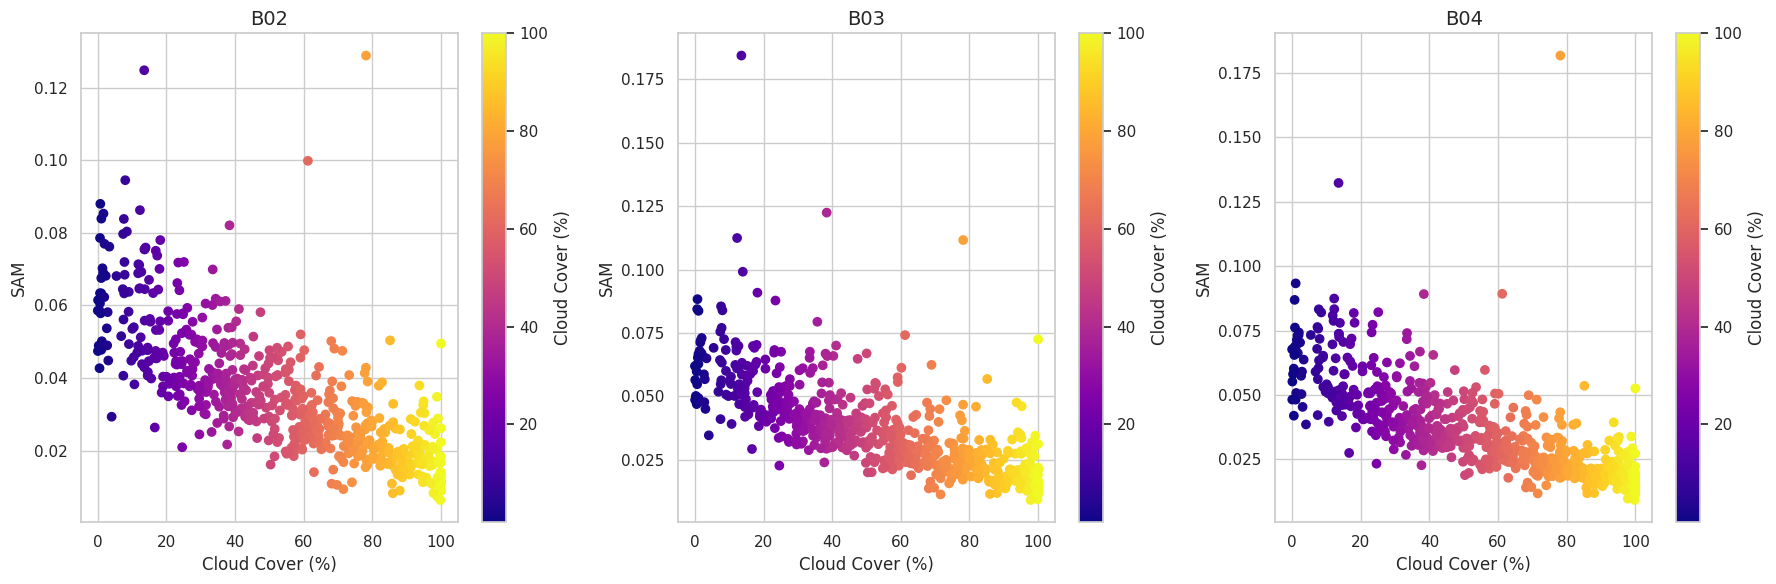

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# Set seaborn style
sns.set(style="whitegrid")

# Example bands
bands = ["B02", "B03", "B04"]

# Set up the figure (1 row x 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define the colormap
cmap = cm.plasma

for i, band in enumerate(bands):
    ax = axs[i]  # Single row, 3 columns
    
    # Scatter plot for SAM with plasma colormap
    scatter = ax.scatter(
        data=df_test_output,
        x='cloud_cover',
        y=f'sam_{band}',
        c=df_test_output['cloud_cover'],  # Color by cloud_cover
        cmap=cmap  # Apply the plasma colormap
    )
    
    # Set title and labels
    ax.set_title(f"{band}", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SAM", fontsize=12)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.show()


## Plot SAM vs % Valid Pixel

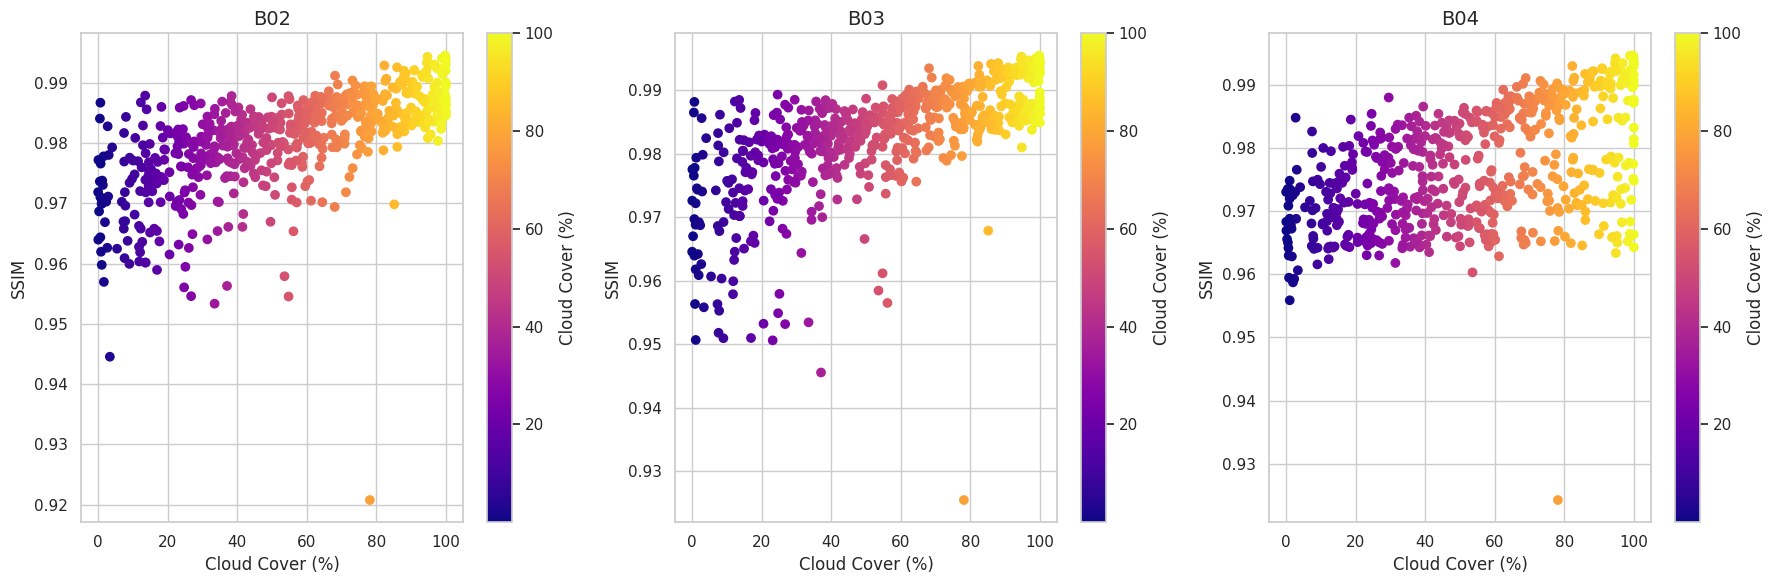

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# Set seaborn style
sns.set(style="whitegrid")

# Example bands
bands = ["B02", "B03", "B04"]

# Set up the figure (1 row x 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define the colormap
cmap = cm.plasma

for i, band in enumerate(bands):
    ax = axs[i]  # Single row, 3 columns
    
    # Scatter plot for SAM with plasma colormap
    scatter = ax.scatter(
        data=df_test_output,
        x='cloud_cover',
        y=f'ssim_{band}',
        c=df_test_output['cloud_cover'],  # Color by cloud_cover
        cmap=cmap  # Apply the plasma colormap
    )
    
    # Set title and labels
    ax.set_title(f"{band}", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SSIM", fontsize=12)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.show()

## Identification of max SAM and PSNR with product investigation